<a href="https://colab.research.google.com/github/sisyphm/diffusers_study/blob/main/LoRA_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers accelerate peft diffusers

In [3]:
from diffusers import DiffusionPipeline
import torch

pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.float16).to("cuda")

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

toy_face_sdxl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

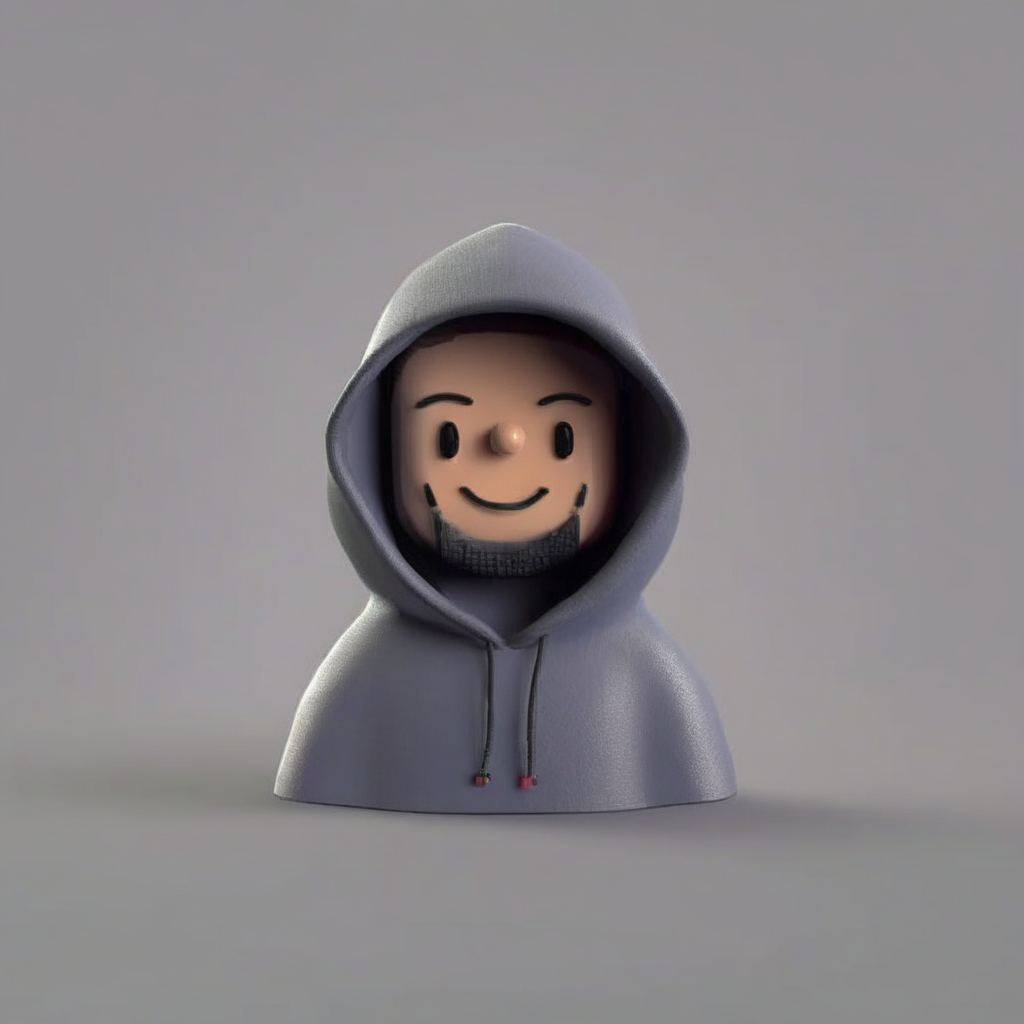

In [5]:
prompt = "toy_face of a hacker with a hoodie"

lora_scale = 0.9
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

In [6]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters("pixel")

pixel-art-xl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

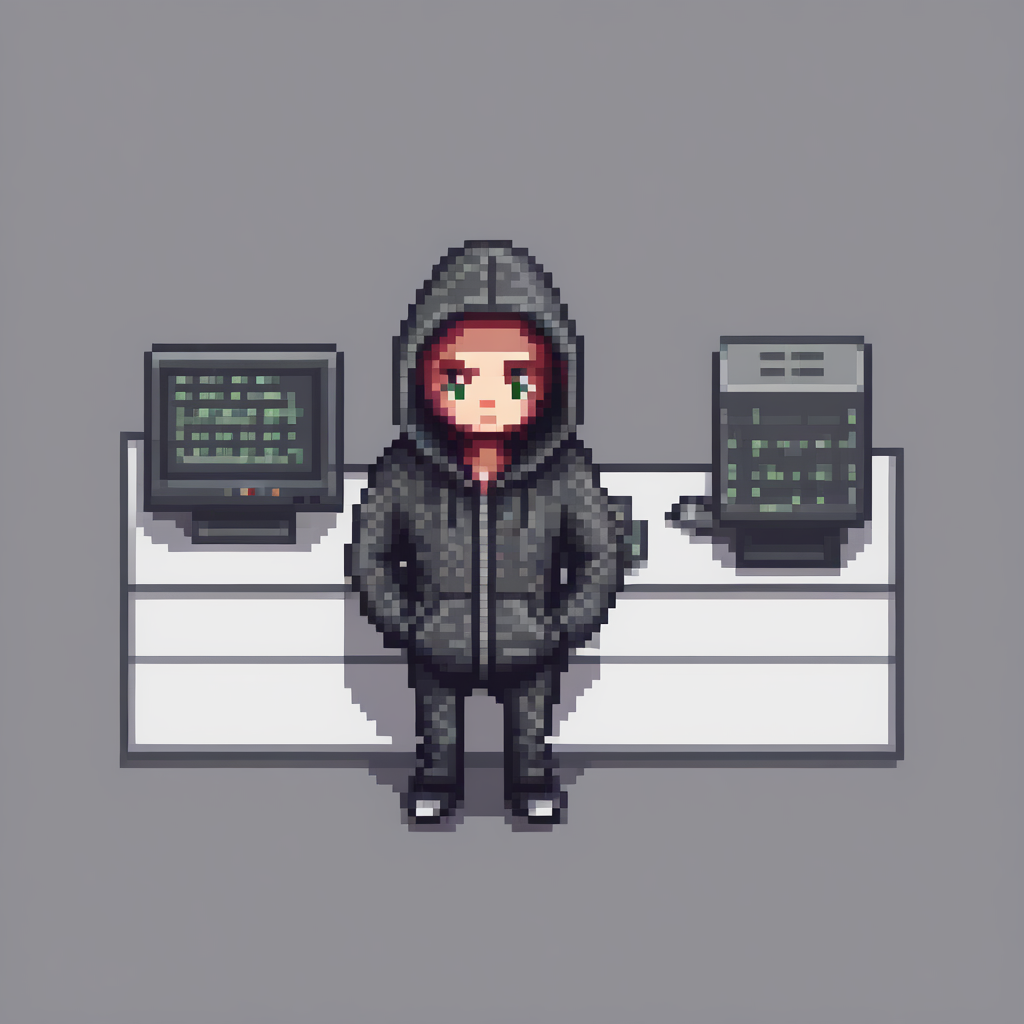

In [9]:
prompt = "a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

In [10]:
pipe.set_adapters(["pixel", "toy"], adapter_weights=[0.5, 1.0])

  0%|          | 0/30 [00:00<?, ?it/s]

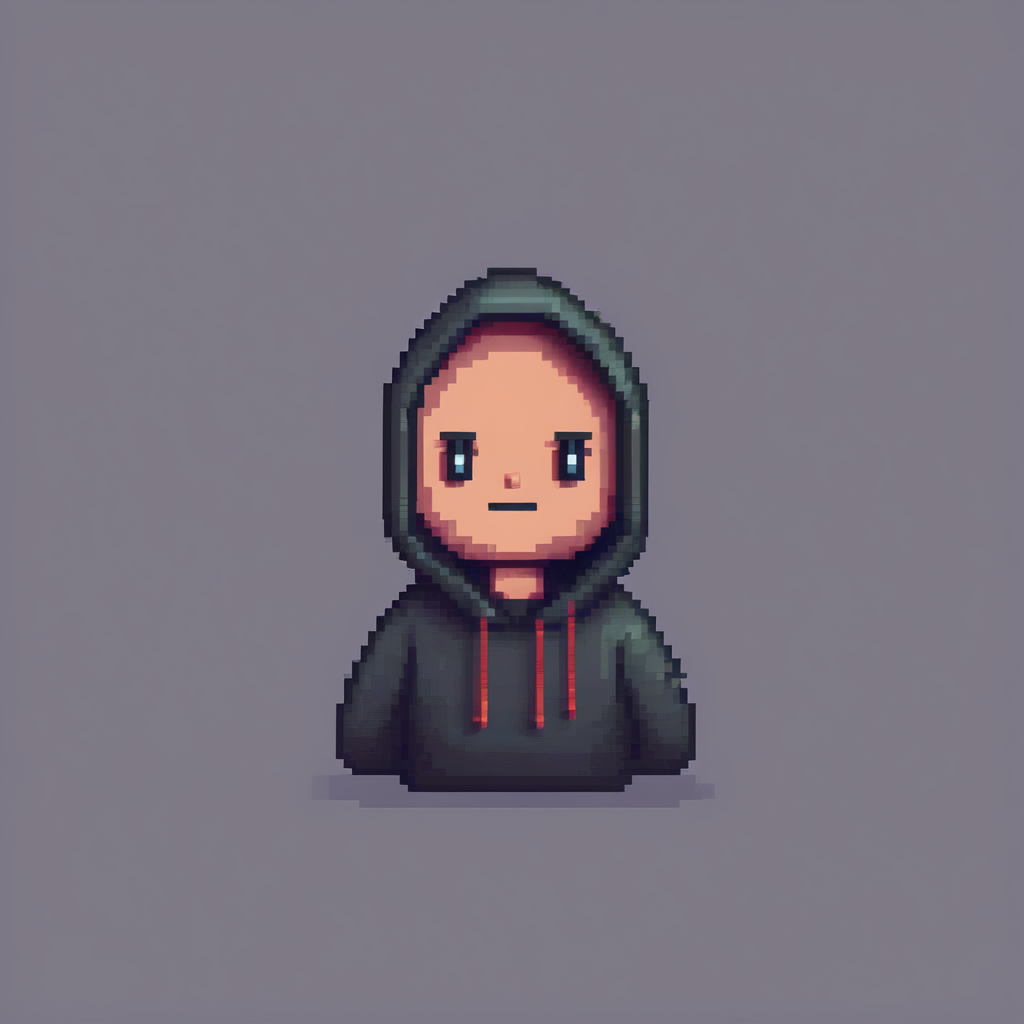

In [11]:
prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": 1.0}, generator=torch.manual_seed(0)
).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

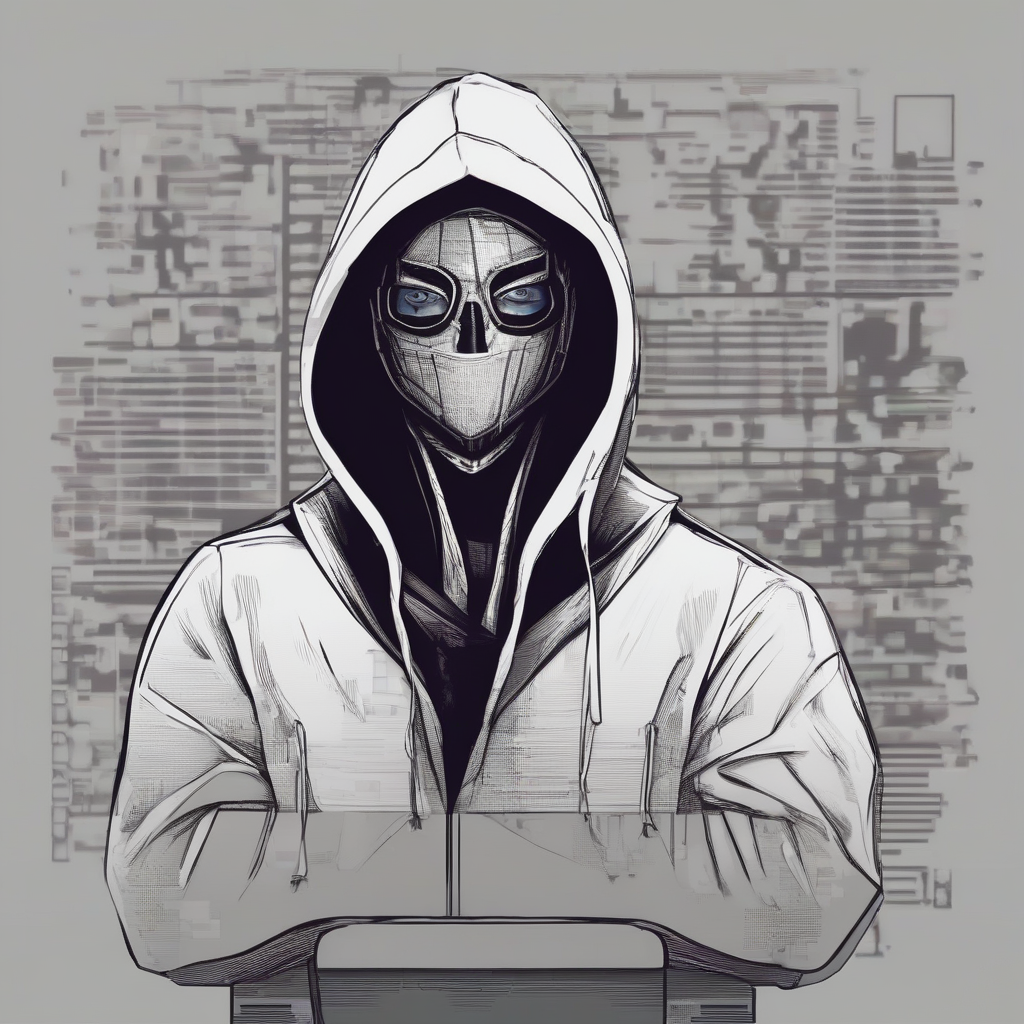

In [12]:
pipe.disable_lora()

prompt = "toy_face of a hacker with a hoodie"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

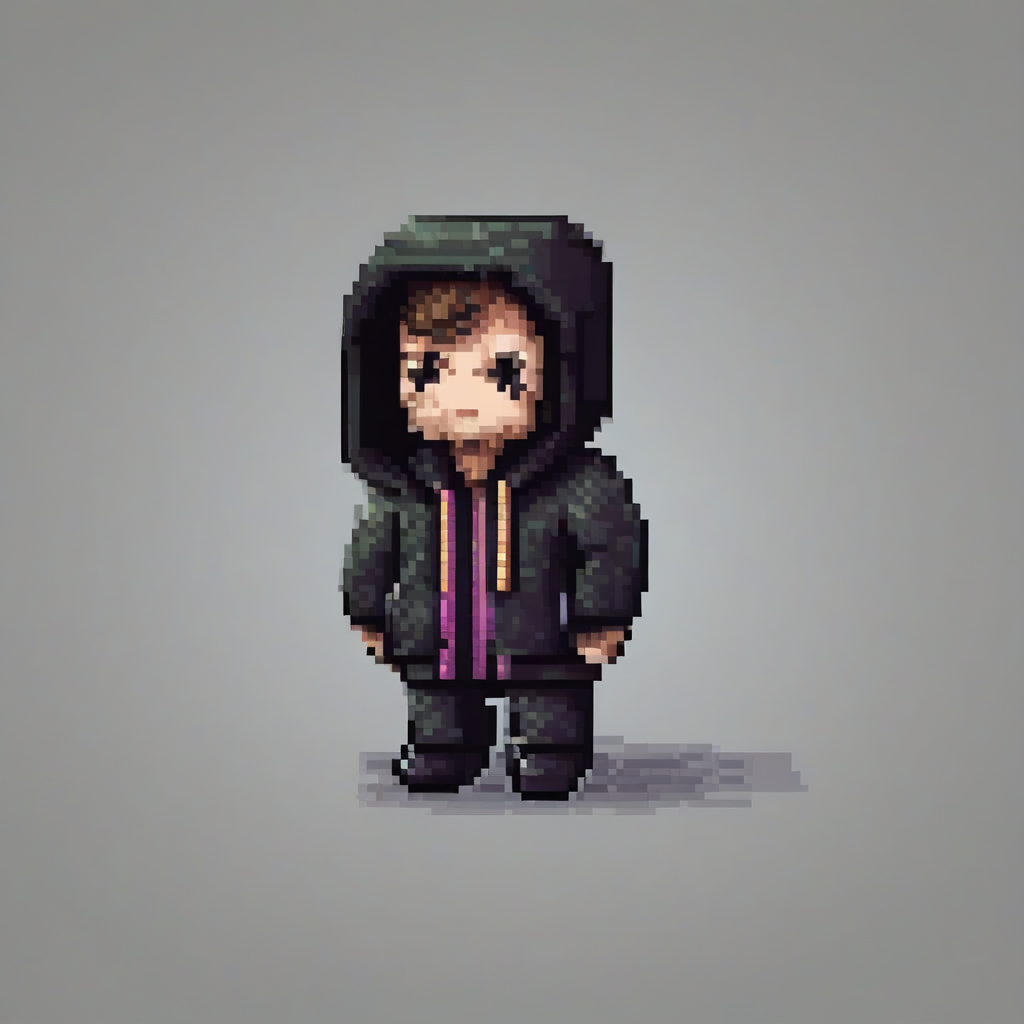

In [13]:
pipe.enable_lora()  # enable lora again, after we disabled it above
prompt = "toy_face of a hacker with a hoodie, pixel art"
adapter_weight_scales = { "unet": { "down": 1, "mid": 0, "up": 0} }
pipe.set_adapters("pixel", adapter_weight_scales)
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

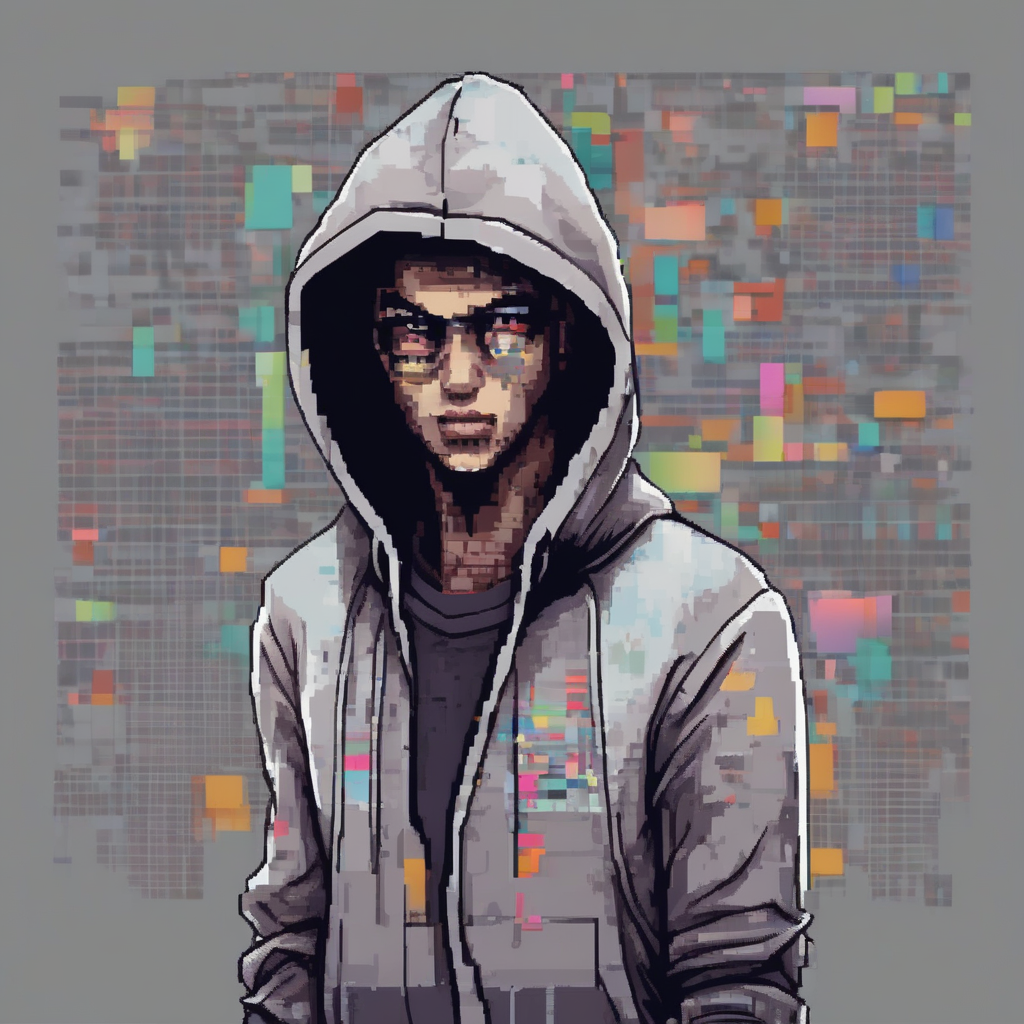

In [14]:
adapter_weight_scales = { "unet": { "down": 0, "mid": 1, "up": 0} }
pipe.set_adapters("pixel", adapter_weight_scales)
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

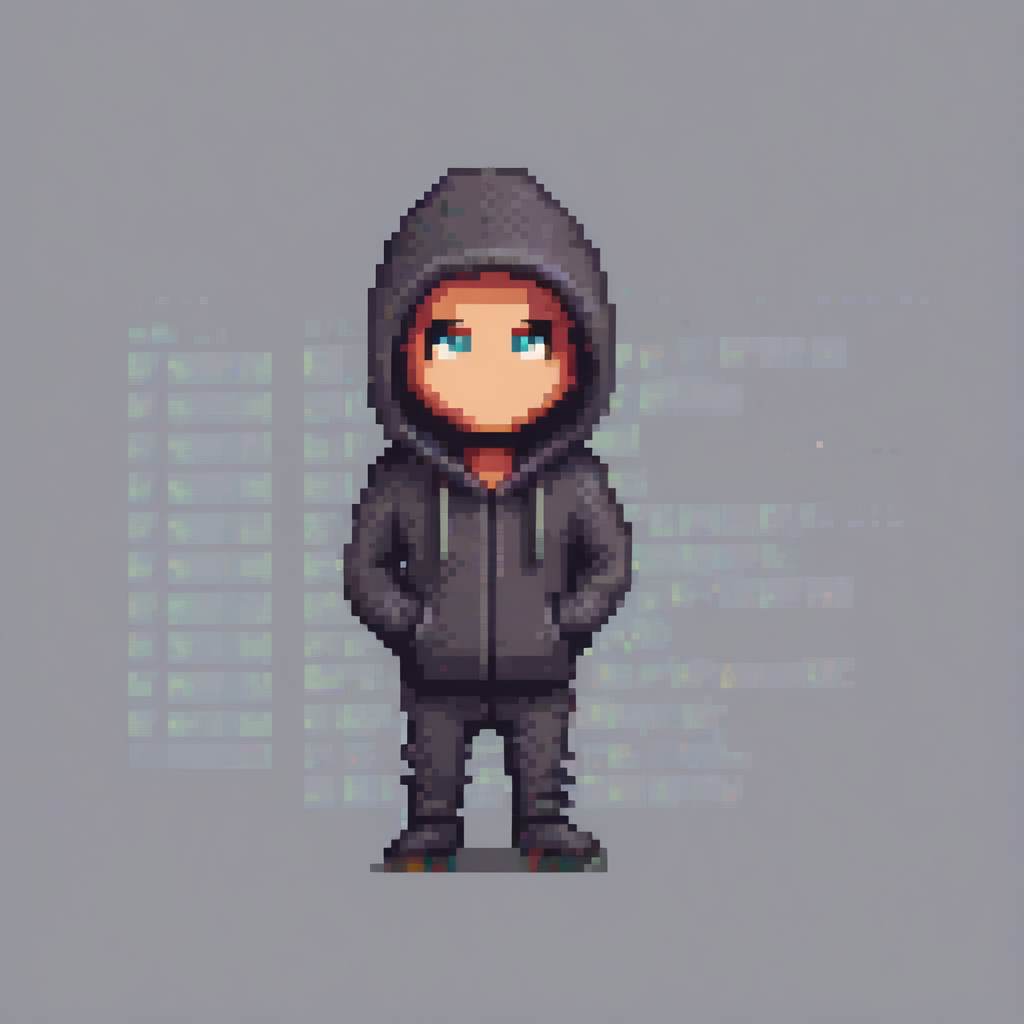

In [15]:
adapter_weight_scales = { "unet": { "down": 0, "mid": 0, "up": 1} }
pipe.set_adapters("pixel", adapter_weight_scales)
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

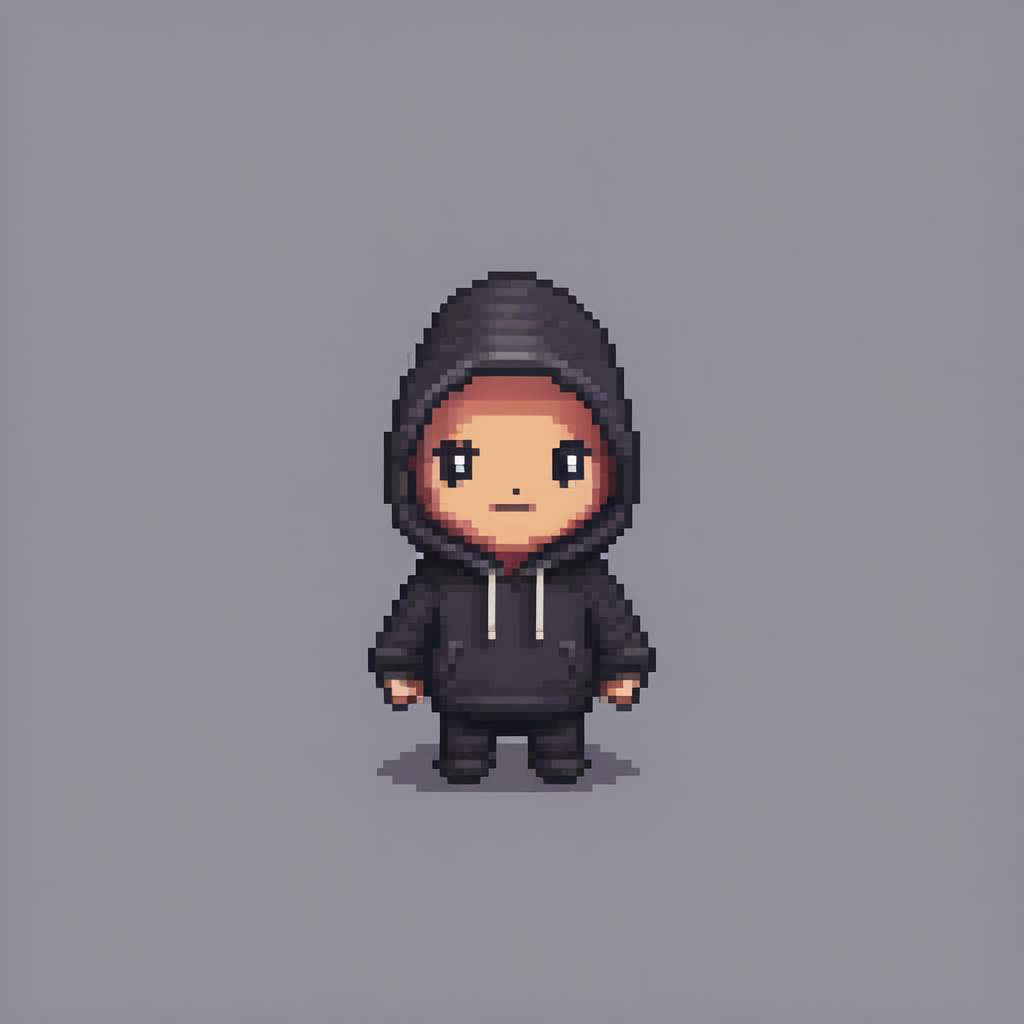

In [16]:
adapter_weight_scales_toy = 0.5
adapter_weight_scales_pixel = {
    "unet": {
        "down": 0.9,  # all transformers in the down-part will use scale 0.9
        # "mid"  # because, in this example, "mid" is not given, all transformers in the mid part will use the default scale 1.0
        "up": {
            "block_0": 0.6,  # all 3 transformers in the 0th block in the up-part will use scale 0.6
            "block_1": [0.4, 0.8, 1.0],  # the 3 transformers in the 1st block in the up-part will use scales 0.4, 0.8 and 1.0 respectively
        }
    }
}
pipe.set_adapters(["toy", "pixel"], [adapter_weight_scales_toy, adapter_weight_scales_pixel])
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

In [21]:
active_adapters = pipe.get_active_adapters()
active_adapters

['toy', 'pixel']

In [22]:
list_adapters_component_wise = pipe.get_list_adapters()
list_adapters_component_wise

{'unet': ['toy', 'pixel']}

In [23]:
pipe.delete_adapters("toy")
pipe.get_active_adapters()

['pixel']